In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from aws.s3_utils import save_dataframe_to_s3, load_dataframe_from_s3, save_model_to_s3, load_model_from_s3
from sklearn.preprocessing import OneHotEncoder


In [3]:
df = load_dataframe_from_s3('data/box_scores/current.parquet')

# Defensive: check for required columns
required_cols = {'MIN'}
if not required_cols.issubset(df.columns):
    print(f"[Fallback] One or more required columns {required_cols} not found in data/box_scores/current.parquet.")
else:
    df = df[df['MIN'] != 0]
    print(df.describe())
print(df.head())

                           GAME DATE            FP       CLUSTER  \
count                          26306  26306.000000  20729.000000   
mean   2025-01-17 05:20:20.436402176     21.725698      7.391336   
min              2024-10-22 00:00:00     -3.000000      0.000000   
25%              2024-12-01 00:00:00     10.000000      4.000000   
50%              2025-01-17 00:00:00     20.000000      8.000000   
75%              2025-03-04 00:00:00     31.200000     11.000000   
max              2025-04-13 00:00:00     98.300000     14.000000   
std                              NaN     14.903955      3.960617   

       Last3_FP_Avg  Last5_FP_Avg  Last7_FP_Avg  Season_FP_Avg  
count  26306.000000  26306.000000  26306.000000   26306.000000  
mean      21.606371     21.516859     21.448126      20.836934  
min       -1.000000     -1.000000     -1.000000      -1.000000  
25%       11.800000     12.100000     12.135714      12.000000  
50%       20.100000     20.040000     19.928571      19.100000

In [4]:
players_df = load_dataframe_from_s3('data/advanced_player_stats/current.parquet')
clustered_players_df = load_dataframe_from_s3('data/clustered_players/current.parquet')

# Use a left merge to add the 'CLUSTER' column to players_df
dataset_clusters = pd.merge(players_df, clustered_players_df[['PLAYER', 'CLUSTER']], on='PLAYER', how='left')

print(dataset_clusters.head())

            PLAYER TEAM   AGE    GP     W     L   MIN  OFFRTG  DEFRTG  NETRTG  \
0   bub carrington  WAS  19.0  82.0  18.0  64.0  30.0   102.8   118.0   -15.2   
1      buddy hield  GSW  32.0  82.0  48.0  34.0  22.7   112.3   110.1     2.2   
2       chris paul  SAS  40.0  82.0  34.0  48.0  28.0   114.2   115.0    -0.8   
3  harrison barnes  SAS  33.0  82.0  34.0  48.0  27.2   114.5   115.6    -1.2   
4  jaden mcdaniels  MIN  24.0  82.0  49.0  33.0  31.9   113.9   109.9     4.0   

   ... FGM_UAST_PERCENT DEF_RTG DREB_PERCENT_TEAM STL_PERCENT BLK_PERCENT  \
0  ...             43.3   118.0              11.7        14.6         7.9   
1  ...             18.9   110.1              11.1        20.3        13.2   
2  ...             62.7   115.0              11.0        26.8         8.3   
3  ...             23.6   115.6               9.1        10.8         5.6   
4  ...             30.4   109.9              12.6        25.5        27.2   

  OPP_PTS_OFFTO OPP_PTS_2ND_CHANCE OPP_PTS_FB OPP_

In [5]:
dataset_clusters.head(10)

,PLAYER,TEAM,AGE,GP,W,L,MIN,OFFRTG,DEFRTG,NETRTG,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,CLUSTER
0,bub carrington,WAS,19.0,82.0,18.0,64.0,30.0,102.8,118.0,-15.2,...,43.3,118.0,11.7,14.6,7.9,12.3,9.9,11.2,33.2,10.0
1,buddy hield,GSW,32.0,82.0,48.0,34.0,22.7,112.3,110.1,2.2,...,18.9,110.1,11.1,20.3,13.2,7.5,6.2,6.9,22.9,2.0
2,chris paul,SAS,40.0,82.0,34.0,48.0,28.0,114.2,115.0,-0.8,...,62.7,115.0,11.0,26.8,8.3,9.3,8.6,9.3,28.7,10.0
3,harrison barnes,SAS,33.0,82.0,34.0,48.0,27.2,114.5,115.6,-1.2,...,23.6,115.6,9.1,10.8,5.6,9.2,8.5,9.4,28.9,12.0
4,jaden mcdaniels,MIN,24.0,82.0,49.0,33.0,31.9,113.9,109.9,4.0,...,30.4,109.9,12.6,25.5,27.2,11.3,8.7,9.9,31.2,9.0
5,jalen green,HOU,23.0,82.0,52.0,30.0,32.9,113.8,111.1,2.8,...,63.2,111.1,12.0,15.3,10.3,11.4,9.4,9.9,34.9,10.0
6,jarrett allen,CLE,27.0,82.0,64.0,18.0,28.0,121.9,111.3,10.5,...,17.5,111.3,23.8,18.2,38.6,9.6,7.9,10.1,28.6,14.0
7,julian champagnie,SAS,24.0,82.0,34.0,48.0,23.6,112.3,114.5,-2.1,...,11.2,114.5,12.1,18.3,14.4,8.3,7.9,8.2,24.0,5.0
8,malik beasley,DET,28.0,82.0,44.0,38.0,27.8,113.3,110.2,3.1,...,15.6,110.2,6.9,19.6,1.9,10.1,8.5,8.0,26.9,2.0
9,mikal bridges,NYK,28.0,82.0,51.0,31.0,37.0,118.4,112.9,5.6,...,24.2,112.9,6.3,14.7,17.6,11.9,9.8,11.4,38.7,12.0


In [6]:
clusterDict = {}
df.describe()

,GAME DATE,FP,CLUSTER,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg
count,26306,26306.000000,20729.000000,26306.000000,26306.000000,26306.000000,26306.000000
mean,2025-01-17 05:20:20.436402176,21.725698,7.391336,21.606371,21.516859,21.448126,20.836934
min,2024-10-22 00:00:00,-3.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2024-12-01 00:00:00,10.000000,4.000000,11.800000,12.100000,12.135714,12.000000
50%,2025-01-17 00:00:00,20.000000,8.000000,20.100000,20.040000,19.928571,19.100000
75%,2025-03-04 00:00:00,31.200000,11.000000,29.800000,29.460000,29.310714,28.111664
max,2025-04-13 00:00:00,98.300000,14.000000,81.600000,80.120000,75.671429,72.200000
std,NaN,14.903955,3.960617,12.969876,12.531316,12.336890,11.822689


In [7]:
# Map the 'Cluster' column from clusterdf to the dataset based on 'Player'
clusterDict = dataset_clusters.set_index('PLAYER')['CLUSTER'].to_dict()

# Map the 'CLUSTER' column in the dataset
df['CLUSTER'] = df['PLAYER'].map(clusterDict)

In [8]:
# Remove players without a cluster
# df = df.dropna(subset=['CLUSTER'])
df.sort_values(by=['GAME DATE'], ascending = [False], inplace=True)
print(df['CLUSTER'].value_counts(dropna=False))


CLUSTER
NaN     5577
2.0     2321
10.0    2274
12.0    2077
5.0     2035
9.0     1654
11.0    1612
3.0     1584
13.0    1258
6.0     1231
1.0     1211
8.0     1118
7.0     1027
14.0     704
4.0      606
0.0       17
Name: count, dtype: int64


In [9]:
print("Data type:", df['MIN'].dtype)
df['MIN'] = pd.to_numeric(df['MIN'], errors='coerce')
print("Data type:", df['MIN'].dtype)
print(df['MIN'].head(10))
df['MIN'] = df['MIN'] + np.random.uniform(-3, 3, size=len(df))
df['MIN'] = df['MIN'].clip(lower=0)
df['MIN']

Data type: object
Data type: int64
24512    33
7396     31
18621    21
17247    30
2870     37
23118    16
12525    33
24271    22
3661     34
808      16
Name: MIN, dtype: int64


24512    33.058723
7396     30.188861
18621    19.120237
17247    30.160389
2870     37.451391
           ...    
25038     5.749750
17175    17.120374
5061     15.533213
17939    12.883676
3590     21.063945
Name: MIN, Length: 26306, dtype: float64

In [10]:
# Replace NaN with a placeholder before encoding
df['CLUSTER'] = df['CLUSTER'].fillna('CLUSTER_NAN')
featureNames = ['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER', 'MIN']
labelName = ['FP']
dfFeatures = df[featureNames]
dfLabels = df[labelName]
# Ensures Cluster is a categorical variable; one-hot encoded
dfFeatures = pd.get_dummies(dfFeatures, columns=['CLUSTER'], drop_first=False)

In [11]:
labels = np.array(dfLabels)
features = np.array(dfFeatures)

In [12]:
df = df[['PLAYER', 'GAME DATE', 'FP', 'Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg', 'CLUSTER', 'MIN']]
players = df['PLAYER']
gameDates = df['GAME DATE']

In [13]:
train, test, trainLabels, testLabels, trainPlayers, testPlayers, trainDates, testDates= train_test_split(features, labels, players, gameDates, test_size=0.25, random_state=30)
testPlayers = testPlayers.reset_index(drop=True)
testDates = testDates.reset_index(drop=True)


In [14]:
import pickle
rf = RandomForestRegressor(
    random_state=4,
)
rf.fit(train, trainLabels)

save_model_to_s3(rf, "models/RFCluster.sav")

C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model\venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [15]:
train_predictions = rf.predict(train)
predictions = rf.predict(test)


In [16]:
# Create a mapping from one-hot encoded columns back to cluster numbers
cluster_columns = [col for col in dfFeatures.columns if col.startswith('CLUSTER_')]
reverse_cluster_map = {i: col.split('_')[-1] for i, col in enumerate(cluster_columns, start=1)}

In [17]:
feature_columns = dfFeatures.columns
df = pd.DataFrame(test, columns = feature_columns)
df['CLUSTER'] = df[cluster_columns].idxmax(axis=1)  # Get the column with the highest value (1 in this case)
# Map back to original cluster numbers safely
def safe_cluster_map(value):
    if isinstance(value, str) and value.startswith('CLUSTER_'):
        try:
            return float(value.split('_')[-1])
        except ValueError:
            return np.nan
    return np.nan

df['CLUSTER'] = df['CLUSTER'].map(safe_cluster_map)

# Drop the one-hot encoded columns if no longer needed
df = df.drop(columns=cluster_columns)
df['PLAYER'] = testPlayers
df['GAME DATE'] = testDates
df['ACTUAL'] = testLabels
df['PREDICTED'] = predictions
df['ERROR'] = abs(df['ACTUAL'] - df['PREDICTED'])
df = df[['PLAYER'] + [col for col in df.columns if col != 'PLAYER']]

In [18]:
df.describe()

,CLUSTER,GAME DATE,ACTUAL,PREDICTED,ERROR
count,5200.000000,6577,6577.000000,6577.000000,6577.000000
mean,7.477115,2025-01-17 04:48:34.155389952,21.875855,21.843713,5.128620
min,0.000000,2024-10-22 00:00:00,-2.000000,-1.130000,0.000000
25%,4.000000,2024-12-01 00:00:00,10.000000,11.345000,1.735000
50%,8.000000,2025-01-17 00:00:00,20.200000,20.565000,3.937000
75%,11.000000,2025-03-05 00:00:00,31.400000,30.790000,7.329000
max,14.000000,2025-04-13 00:00:00,98.300000,79.366000,37.455000
std,3.909076,NaN,15.030971,13.516208,4.432239


In [19]:
df.head(5)

,PLAYER,Last3_FP_Avg,Last5_FP_Avg,Last7_FP_Avg,Season_FP_Avg,MIN,CLUSTER,GAME DATE,ACTUAL,PREDICTED,ERROR
0,cj mccollum,31.233333,32.14,34.357143,34.357143,35.511642,10.0,2024-11-29,39.8,34.463,5.337
1,jaylen clark,6.733333,11.56,11.8,10.35,8.058118,NaN,2025-04-01,6.4,5.819,0.581
2,derrick white,26.0,29.74,30.385714,31.756863,35.370841,12.0,2025-02-10,26.3,27.690,1.390
3,jalen hood-schifino,13.966667,15.16,18.0,14.68,25.92668,3.0,2025-03-30,28.9,16.826,12.074
4,kylor kelley,3.7,2.66,7.342857,7.15,5.295683,NaN,2025-02-23,4.7,2.326,2.374


In [20]:
save_dataframe_to_s3(df, 'data/test_player_predictions/current.parquet')
players_df = load_dataframe_from_s3('data/advanced_player_stats/current.parquet')
clustered_players_df = load_dataframe_from_s3('data/clustered_players/current.parquet')

# Use a left merge to add the 'CLUSTER' column to players_df
dataset_clusters = pd.merge(players_df, clustered_players_df[['PLAYER', 'CLUSTER']], on='PLAYER', how='left')

print(dataset_clusters.head())

Saved 6577 records to s3://nba-prediction-ibracken/data/test_player_predictions/current.parquet
            PLAYER TEAM   AGE    GP     W     L   MIN  OFFRTG  DEFRTG  NETRTG  \
0   bub carrington  WAS  19.0  82.0  18.0  64.0  30.0   102.8   118.0   -15.2   
1      buddy hield  GSW  32.0  82.0  48.0  34.0  22.7   112.3   110.1     2.2   
2       chris paul  SAS  40.0  82.0  34.0  48.0  28.0   114.2   115.0    -0.8   
3  harrison barnes  SAS  33.0  82.0  34.0  48.0  27.2   114.5   115.6    -1.2   
4  jaden mcdaniels  MIN  24.0  82.0  49.0  33.0  31.9   113.9   109.9     4.0   

   ... FGM_UAST_PERCENT DEF_RTG DREB_PERCENT_TEAM STL_PERCENT BLK_PERCENT  \
0  ...             43.3   118.0              11.7        14.6         7.9   
1  ...             18.9   110.1              11.1        20.3        13.2   
2  ...             62.7   115.0              11.0        26.8         8.3   
3  ...             23.6   115.6               9.1        10.8         5.6   
4  ...             30.4   109.9 

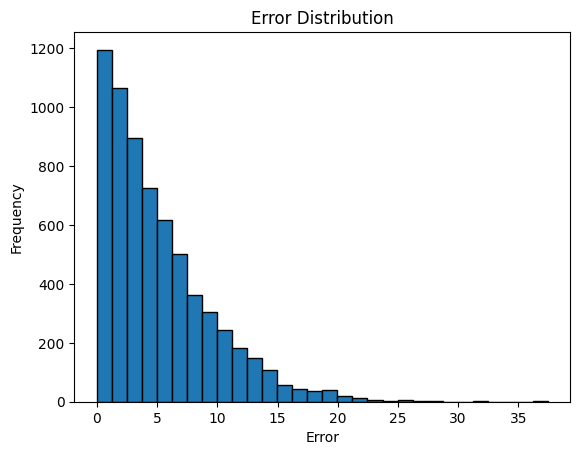

In [21]:
import matplotlib.pyplot as plt

plt.hist(df['ERROR'], bins=30, edgecolor='k')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()

In [22]:
# Identfy unique list of cluster to loop over
dataset_clusters.head()

,PLAYER,TEAM,AGE,GP,W,L,MIN,OFFRTG,DEFRTG,NETRTG,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,CLUSTER
0,bub carrington,WAS,19.0,82.0,18.0,64.0,30.0,102.8,118.0,-15.2,...,43.3,118.0,11.7,14.6,7.9,12.3,9.9,11.2,33.2,10.0
1,buddy hield,GSW,32.0,82.0,48.0,34.0,22.7,112.3,110.1,2.2,...,18.9,110.1,11.1,20.3,13.2,7.5,6.2,6.9,22.9,2.0
2,chris paul,SAS,40.0,82.0,34.0,48.0,28.0,114.2,115.0,-0.8,...,62.7,115.0,11.0,26.8,8.3,9.3,8.6,9.3,28.7,10.0
3,harrison barnes,SAS,33.0,82.0,34.0,48.0,27.2,114.5,115.6,-1.2,...,23.6,115.6,9.1,10.8,5.6,9.2,8.5,9.4,28.9,12.0
4,jaden mcdaniels,MIN,24.0,82.0,49.0,33.0,31.9,113.9,109.9,4.0,...,30.4,109.9,12.6,25.5,27.2,11.3,8.7,9.9,31.2,9.0


In [23]:
clusterList = dataset_clusters['CLUSTER'].tolist()

In [24]:
uniqueClusterList = list(set(clusterList))
uniqueClusterList

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,

In [25]:
# ClusterError = 0
# for cluster in uniqueClusterList:
#     clusterdf = dataset[dataset['CLUSTER'] == cluster]
#     dfFeatures = clusterdf[['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg']]
#     dfLabels = clusterdf[['FP']]

#     labels = np.array(dfLabels).ravel()
#     features = np.array(dfFeatures)

#     train, test, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=4)

#     reg = RandomForestRegressor(random_state=4)
#     reg.fit(train, train_labels)

#     train_predictions = reg.predict(train)
#     predictions = reg.predict(test)

#     df0 = pd.DataFrame(test, columns = ['Last3_FP_Avg', 'Last5_FP_Avg', 'Last7_FP_Avg', 'Season_FP_Avg'])
#     df0['Actual'] = test_labels
#     df0['Predicted'] = predictions
#     df0['Error'] = abs(df0['Actual'] - df0['Predicted'])
#     ClusterError += df0['Error'].mean()

#     print(f"Cluster {cluster} average error is roughly {df0['Error'].mean()}")
# avgClusterError = ClusterError/len(uniqueClusterList)
# print(f"Average error across clusters is: {avgClusterError}")